# Solution 1

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from binomial import *

In [2]:
dt = .5
T = .5
rate_tree = construct_rate_tree(dt,T)

rate_tree[.5] = [.0339,.0095]
rate_tree.loc[0,0] = .0174
format_bintree(rate_tree,style='{:.2%}')

time,0.00,0.50
state,,
0,1.74%,3.39%
1,,0.95%


#### Note on displaying trees in pandas

The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

### Market Quotes

This is the current term-structure observed at $t=0$.

In [3]:
maturities = [.5,1,1.5]
prices = [99.1338,97.8925,96.1462]
quotes = construct_quotes(maturities,prices)
quotes.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

### 1.4 
What is the price of the swap?

#### Note on swaps
Swaps actually pay in arrears, so the rate at period $t=1$ determines the cashflow at $t=1.5.$ Here, we simplify and consider a swap that pays immediately, at time $t=1$.

# **<span style="color:red">Solution 1</span>**

In [4]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

### Note on programming

The solutions explicitly code formulas for some solutions for pedagogical reasons.

Otherwise, the other solutions make use of functions to do most of these calculations.

### Parameters

In [5]:
MATUND = 1
FACE = 100

### Calculate tree for bond with $T=1$

In [6]:
bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

for i in bond_tree.columns[-1:0:-1]:
    bond_tree[i] = np.exp(-rate_tree[i]*(MATUND-i)) * FACE

bond_tree.iloc[0,0] = quotes.loc[MATUND,'price']
bond_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time,0.0,0.5
state,,
0,97.8925,98.3193
1,nan,99.5261


### Calculate $p^*$

In [7]:
A = np.exp(rate_tree.iloc[0,0] * dt)
Z = np.exp(-rate_tree.iloc[0,0] * dt)

pstar = (A * bond_tree.loc[0,0] - bond_tree.loc[1,dt])/(bond_tree.loc[0,dt] - bond_tree.loc[1,dt])

pvec = pd.DataFrame([pstar,1-pstar],index=['prob up','prob down'],columns=[''])
pvec.style.format('{:.2%}')

,
prob up,64.49%
prob down,35.51%


### Swap tree

In [8]:
STRIKE = .02
payoff = lambda r: FACE/2 * (r-STRIKE)
swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
swap_tree[dt] = payoff(rate_tree[dt])

### Replicating portfolio

The replicating portfolios are listed below for pedagogy. Given the risk-neutral probabilities, they are not needed to calculate the price.

In [9]:
bond_tree

time,0.0,0.5
state,,
0,97.8925,98.319284
1,NaN,99.526126


In [10]:
replicating_port(quotes.loc[[.5,1],'price'].values, bond_tree, swap_tree).style.format('{:.4f}')

,positions,value
cash,1.0009,99.1338
under,-1.0109,97.8925
derivative,nan,0.2595


### Calculate Swap Value

In [11]:
swap_tree.loc[0,0] = Z * np.array([pstar,1-pstar])@ swap_tree[dt].values
swap_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time,0.0,0.5
state,,
0,0.2595,0.6950
1,nan,-0.5250


***

# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Price the derivative with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing. 

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and the swap. 

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

# **<span style="color:red">Solution 2</span>**

### Swap tree

See the swap tree above.

In [12]:
EXPIRATION = .5
STRIKE = .02
payoff = lambda r: FACE * np.maximum(STRIKE - r,0)

### Estimating $p^*$

We determine $p^*$ with the market quotes, which we have on the zero-coupon bonds, along with the rate tree. Accordingly, we get the same $p^*$ here.

If we had market quotes to calibrate the swap prices, then we could use those to estimate $p^*$.

In [13]:
pstars = estimate_pstar(quotes.loc[:rate_tree.index[-1],['price']],rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time,0.00
pstar,64.49%


### Pricing with $p^*$

Using the formulas in a few lines of explicit code...

In [14]:
floorlet_tree = pd.DataFrame(dtype=float, columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree[EXPIRATION] = payoff(rate_tree[EXPIRATION])
floorlet_tree.loc[0,0] = Z * np.array([pstar, 1-pstar])@floorlet_tree[EXPIRATION]
format_bintree(floorlet_tree,style='{:.4f}')

time,0.00,0.50
state,,
0,0.3697,0.0000
1,,1.0500


Or using a function...

In [15]:
derivtree = bintree_pricing(payoff, rate_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time,0.00,0.50
state,,
0,0.3697,0.0000
1,,1.0500


This price matches the value from the replicating portfolio using the swaps.

### Pricing with replicating portfolio

In [16]:
replicating_port([quotes.loc[.5,'price'],swap_tree.loc[0,0]], swap_tree, floorlet_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,0.0060,99.1338
under,-0.8607,0.2595
derivative,nan,0.3697


***

# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P^{(1)}_{0.5}-K,0)$
* Strike = \$99.00

where $P^{(1)}_{0.5}$ denotes the time $t=0.5$ price of the bond maturing at $t=1$.

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=0.5$ 
* written on the bond maturing in 2 periods, ($t=1$).

# **<span style="color:red">Solution 3</span>**

In [17]:
payoff = lambda p: np.maximum(p-STRIKE,0)
STRIKE = 99
EXPIRATION = .5

In [18]:
pstars = estimate_pstar(quotes.loc[:rate_tree.index[-1],['price']],rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time,0.00
pstar,64.49%


In [19]:
derivtree = bintree_pricing(payoff, rate_tree, undertree=bond_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time,0.00,0.50
state,,
0,0.1852,0.0000
1,,0.5261


In [20]:
replicating_port(quotes.loc[[.5,1],'price'].values, bond_tree, derivtree, dt=.5).style.format('{:.4f}')

,positions,value
cash,-0.4286,99.1338
under,0.4360,97.8925
derivative,nan,0.1852


***

# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [21]:
newcol = pd.Series([.05,.0256,.0011],name=1)

ratetree_multi = construct_rate_tree(dt=.5, T=1)
ratetree_multi.iloc[:-1,[0,1]] = rate_tree
ratetree_multi[1] = newcol
format_bintree(ratetree_multi,'{:.2%}')

time,0.00,0.50,1.00
state,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European put option?
* option expires at $T_{\text{deriv}}=1$
* written on bond maturing at $T_{\text{bond}}=1.5$
* strike = 99

### 4.4
Re-do 4.3 but for an American-style option.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

# **<span style="color:red">Solution 4</span>**

In [22]:
pstars = estimate_pstar(quotes,ratetree_multi)

payoff = lambda r: payoff_bond(r,dt)

bondtree_multi = bintree_pricing(payoff, ratetree_multi, pstars=pstars)
format_bintree(bondtree_multi, style='{:.4f}')

time,0.00,0.50,1.00
state,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


### Put on bond

In [23]:
STRIKE = 99
payoff = lambda p: np.maximum(STRIKE-p,0)

derivtree = bintree_pricing(payoff, ratetree_multi, undertree = bondtree_multi, pstars=pstars)
format_bintree(derivtree, style='{:.4f}')

time,0.00,0.50,1.00
state,,,
0,0.8379,1.1935,1.4690
1,,0.2129,0.2718
2,,,0.0000


### American 

In [24]:
derivtree = bintree_pricing(payoff, ratetree_multi, undertree=bondtree_multi, pstars=pstars, style='american')
format_bintree(derivtree, style='{:.4f}')

time,0.00,0.50,1.00
state,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


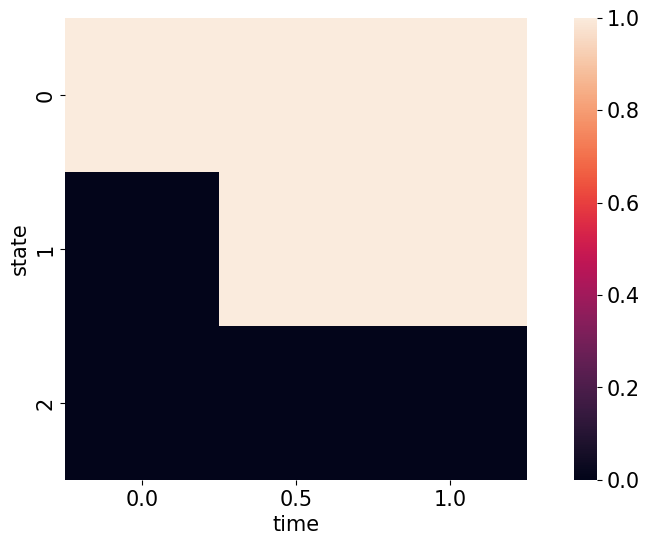

In [25]:
sns.heatmap(exercise_decisions(payoff,bondtree_multi, derivtree), square=True);

***

# 5 American Style

## *Optional: no need to submit this solution.*

Consider a finer time grid. Let $dt$ in the tree now be 0.02 instead of 0.5.

### 5.1
Using this smaller time step, compute the $t=0$ price of the put option in part 4:
* option expires at $T_{\text{deriv}}=1$
* written on bond maturing at $T_{\text{bond}}=1.5$
* strike of \$99

### 5.2
Price the same option with the finer time grid, but now for an American exercise
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

# **<span style="color:red">Solution 5</span>**

### Building the rate tree

We immediately have questions about how to build the rate tree.

1. Multiplicative up/down factors as in the lecture note.
2. Additive up/down factors trying t

For either of these choices...
* Should we match vol of rates or levels of rates?
* How far out do we need to model the rates?

Given that the bond matures at $T=1.5$, we need to model rates out to (one step less than) that maturity. 
* Do either of the choices above lead to reasonable choices out to $T=1.5$?

In [26]:
dt = 1/50
TMAT = 1.5

SIM_ADDITIVE = False

if SIM_ADDITIVE:
    sigma = .01
    mu_growth = .0050
    up = mu_growth * dt + sigma * np.sqrt(dt)
    down = mu_growth * dt - sigma * np.sqrt(dt)/2
else:
    sigma = .30
    up = np.exp(sigma*np.sqrt(dt))
    down = np.exp(-sigma*np.sqrt(dt))

ratetree_dense = construct_rate_tree(dt, TMAT-dt)
ratetree_dense.loc[0,0] = rate_tree.loc[0,0]

In [ ]:
for tsteps in range(ratetree_dense.shape[1]-1):
    if SIM_ADDITIVE:
        ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] + up
        ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] + down
    else:
        ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] * up        
        ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] * down

format_bintree(ratetree_dense,style='{:.2%}')

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%,25.20%,26.29%,27.43%,28.62%,29.86%,31.15%,32.50%,33.91%,35.38%,36.91%,38.51%,40.18%
1,,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%,25.20%,26.29%,27.43%,28.62%,29.86%,31.15%,32.50%,33.91%,35.38%,36.91%
2,,,1.60%,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%,25.20%,26.29%,27.43%,28.62%,29.86%,31.15%,32.50%,33.91%
3,,,,1.53%,1.60%,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%,25.20%,26.29%,27.43%,28.62%,29.86%,31.15%
4,,,,,1.47%,1.53%,1.60%,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%,25.20%,26.29%,27.43%,28.62%
5,,,,,,1.41%,1.47%,1.53%,1.60%,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%,25.20%,26.29%
6,,,,,,,1.35%,1.41%,1.47%,1.53%,1.60%,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,9.50%,9.91%,10.34%,10.79%,11.25%,11.74%,12.25%,12.78%,13.33%,13.91%,14.52%,15.14%,15.80%,16.49%,17.20%,17.95%,18.72%,19.53%,20.38%,21.26%,22.19%,23.15%,24.15%
7,,,,,,,,1.29%,1.35%,1.41%,1.47%,1.53%,1.60%,1.67%,1.74%,1.82%,1.89%,1.98%,2.06%,2.15%,2.24%,2.34%,2.44%,2.55%,2.66%,2.77%,2.90%,3.02%,3.15%,3.29%,3.43%,3.58%,3.73%,3.90%,4.06%,4.24%,4.42%,4.62%,4.82%,5.03%,5.24%,5.47%,5.71%,5.96%,6.21%,6.48%,6.76%,7.06%,7.36%,7.68%,8.01%,8.36%,8.72%,9.10%,

### Risk-neutral probability

In order to estimate $p^*$ at each step, we would need a market quote for a bond maturing at each time-step maturity.

We do not have this, so we try pricing by assuming a constant $p^*$ throughout the tree, equal to the first $p^*$ we estimated at $t=0$.

In [28]:
pstars = pd.Series(.65, index=ratetree_dense.columns, name='pstar')

format_bintree(pstars.to_frame().T,style='{:.2%}')

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48
pstar,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%


### Pricing the bond over the tree

In [29]:
payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(payoff, ratetree_dense, pstars = pstars)
format_bintree(bondtree_dense,style='{:.4f}')

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,95.6097,95.5181,95.4255,95.3318,95.2370,95.1412,95.0445,94.9468,94.8483,94.7490,94.6489,94.5482,94.4468,94.3450,94.2426,94.1400,94.0370,93.9340,93.8309,93.7278,93.6250,93.5225,93.4205,93.3192,93.2187,93.1191,93.0208,92.9238,92.8284,92.7349,92.6434,92.5543,92.4677,92.3840,92.3035,92.2265,92.1533,92.0844,92.0201,91.9607,91.9069,91.8589,91.8173,91.7826,91.7554,91.7362,91.7257,91.7244,91.7331,91.7526,91.7835,91.8267,91.8832,91.9537,92.0394,92.1412,92.2602,92.3977,92.5550,92.7332,92.9340,93.1589,93.4093,93.6872,93.9944,94.3329,94.7048,95.1124,95.5582,96.0449,96.5753,97.1525,97.7799,98.4609,99.1996
1,,95.8747,95.7893,95.7029,95.6155,95.5271,95.4379,95.3478,95.2569,95.1652,95.0729,94.9799,94.8864,94.7923,94.6979,94.6031,94.5081,94.4129,94.3177,94.2225,94.1275,94.0329,93.9387,93.8450,93.7522,93.6602,93.5693,93.4797,93.3916,93.3051,93.2206,93.1381,93.0581,92.9807,92.9063,92.8351,92.7675,92.7037,92.6442,92.5894,92.5395,92.4952,92.4567,92.4247,92.3995,92.3818,92.3720,92.3709,92.3789,92.3969,92.4256,92.4656,92.5178,92.5831,92.6623,92.7565,92.8666,92.9938,93.1392,93.3040,93.4896,93.6973,93.9288,94.1855,94.4691,94.7816,95.1248,95.5009,95.9121,96.3607,96.8495,97.3811,97.9586,98.5852,99.2644
2,,,96.1248,96.0451,95.9645,95.8830,95.8007,95.7176,95.6338,95.5493,95.4641,95.3783,95.2920,95.2052,95.1181,95.0306,94.9429,94.8551,94.7672,94.6793,94.5917,94.5043,94.4173,94.3308,94.2451,94.1601,94.0762,93.9934,93.9120,93.8321,93.7540,93.6778,93.6039,93.5324,93.4636,93.3978,93.3353,93.2764,93.2214,93.1707,93.1247,93.0837,93.0481,93.0185,92.9952,92.9788,92.9698,92.9688,92.9763,92.9929,93.0194,93.0564,93.1047,93.1651,93.2384,93.3254,93.4272,93.5448,93.6791,93.8314,94.0029,94.1948,94.4085,94.6455,94.9074,95.1957,95.5124,95.8592,96.2383,96.6518,97.1020,97.5916,98.1231,98.6996,99.3241
3,,,,96.3606,96.2863,96.2112,96.1354,96.0588,95.9815,95.9035,95.8250,95.7458,95.6663,95.5862,95.5058,95.4251,95.3442,95.2632,95.1821,95.1010,95.0201,94.9394,94.8592,94.7794,94.7002,94.6218,94.5443,94.4679,94.3927,94.3190,94.2468,94.1765,94.1082,94.0422,93.9786,93.9178,93.8601,93.8057,93.7549,93.7081,93.6655,93.6276,93.5948,93.5674,93.5459,93.5308,93.5225,93.5215,93.5285,93.5439,93.5684,93.6026,93.6472,93.7030,93.7707,93.8512,93.9452,94.0538,94.1779,94.3186,94.4769,94.6541,94.8514,95.0701,95.3117,95.5777,95.8698,96.1895,96.5389,96.9199,97.3346,97.7853,98.2745,98.8047,99.3789
4,,,,,96.5830,96.5138,96.4438,96.3732,96.3020,96.2301,96.1577,96.0848,96.0114,95.9376,95.8635,95.7891,95.7144,95.6397,95.5649,95.4901,95.4155,95.3411,95.2670,95.1934,95.1203,95.0480,94.9765,94.9059,94.8365,94.7685,94.7019,94.6370,94.5739,94.5129,94.4543,94.3982,94.3449,94.2946,94.2477,94.2045,94.1652,94.1302,94.0999,94.0746,94.0548,94.0408,94.0331,94.0323,94.0387,94.0529,94.0756,94.1072,94.1484,94.2000,94.2625,94.3368,94.4236,94.5239,94.6385,94.7684,94.9145,95.0780,95.2601,95.4619,95.6847,95.9300,96.1993,96.4940,96.8159,97.1669,97.5488,97.9636,98.4137,98.9014,99.4293
5,,,,,,96.7926,96.7281,96.6631,96.5974,96.5312,96.4645,96.3972,96.3296,96.2616,96.1932,96.1246,96.0558,95.9869,95.9179,95.8490,95.7802,95.7115,95.6432,95.5753,95.5079,95.4412,95.3752,95.3102,95.2462,95.1833,95.1219,95.0620,95.0038,94.9476,94.8934,94.8416,94.7924,94.7461,94.7028,94.6629,94.6266,94.5943,94.5663,94.5430,94.5247,94.5118,94.5047,94.5040,94.5099,94.5230,94.5439,94.5731,94.6112,94.6588,94.7166,94.7851,94.8653,94.9579,95.0636,95.1835,95.3183,95.4692,95.6371,95.8232,96.0287,96.2548,96.5030,96.7746,97.0711,97.3943,97.7459,98.1277,98.5418,98.9904,99.4756
6,,,,,,,96.9901,96.9301,96.8697,

### Price the derivative

In [30]:
STRIKE = 99
EXPIRATION = 1

payoff = lambda p: np.maximum(STRIKE-p,0)

ratetreeT = ratetree_dense.loc[:,:EXPIRATION].dropna(axis=0,how='all')
bondtreeT = bondtree_dense.loc[:,:EXPIRATION].dropna(axis=0,how='all')

derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.9760,1.0319,1.0894,1.1487,1.2096,1.2724,1.3369,1.4033,1.4716,1.5419,1.6141,1.6884,1.7649,1.8435,1.9244,2.0076,2.0931,2.1812,2.2718,2.3650,2.4609,2.5596,2.6612,2.7657,2.8734,2.9842,3.0983,3.2157,3.3367,3.4613,3.5897,3.7220,3.8583,3.9988,4.1436,4.2929,4.4469,4.6057,4.7696,4.9387,5.1133,5.2936,5.4798,5.6721,5.8710,6.0765,6.2891,6.5090,6.7366,6.9723,7.2165
1,,0.8733,0.9261,0.9806,1.0367,1.0945,1.1541,1.2153,1.2784,1.3432,1.4099,1.4786,1.5492,1.6218,1.6965,1.7733,1.8524,1.9337,2.0174,2.1035,2.1921,2.2833,2.3772,2.4737,2.5732,2.6755,2.7809,2.8894,3.0011,3.1162,3.2347,3.3568,3.4826,3.6123,3.7459,3.8837,4.0258,4.1723,4.3234,4.4793,4.6402,4.8063,4.9778,5.1549,5.3379,5.5270,5.7225,5.9247,6.1339,6.3503,6.5744
2,,,0.7760,0.8259,0.8774,0.9305,0.9852,1.0416,1.0997,1.1595,1.2211,1.2844,1.3496,1.4166,1.4856,1.5566,1.6296,1.7047,1.7819,1.8615,1.9433,2.0275,2.1141,2.2033,2.2951,2.3896,2.4869,2.5870,2.6902,2.7964,2.9058,3.0185,3.1346,3.2542,3.3775,3.5046,3.6356,3.7706,3.9099,4.0536,4.2019,4.3549,4.5128,4.6759,4.8443,5.0183,5.1980,5.3839,5.5761,5.7749,5.9806
3,,,,0.6842,0.7311,0.7796,0.8298,0.8815,0.9349,0.9900,1.0467,1.1050,1.1651,1.2270,1.2906,1.3561,1.4235,1.4928,1.5641,1.6375,1.7130,1.7907,1.8707,1.9530,2.0377,2.1249,2.2147,2.3071,2.4023,2.5003,2.6013,2.7052,2.8123,2.9226,3.0363,3.1535,3.2743,3.3988,3.5272,3.6596,3.7961,3.9370,4.0824,4.2325,4.3875,4.5475,4.7128,4.8836,5.0602,5.2428,5.4316
4,,,,,0.5976,0.6416,0.6872,0.7344,0.7833,0.8337,0.8858,0.9395,0.9948,1.0518,1.1104,1.1708,1.2329,1.2969,1.3627,1.4304,1.5001,1.5718,1.6456,1.7215,1.7997,1.8801,1.9629,2.0482,2.1360,2.2264,2.3195,2.4154,2.5141,2.6158,2.7206,2.8286,2.9400,3.0547,3.1730,3.2949,3.4207,3.5504,3.6843,3.8224,3.9650,4.1122,4.2642,4.4212,4.5834,4.7511,4.9244
5,,,,,,0.5165,0.5575,0.6001,0.6444,0.6904,0.7379,0.7871,0.8378,0.8902,0.9441,0.9997,1.0570,1.1159,1.1766,1.2390,1.3033,1.3694,1.4375,1.5075,1.5796,1.6538,1.7302,1.8088,1.8897,1.9731,2.0589,2.1473,2.2383,2.3321,2.4287,2.5282,2.6308,2.7365,2.8454,2.9577,3.0736,3.1930,3.3162,3.4433,3.5744,3.7098,3.8495,3.9938,4.1429,4.2969,4.4561
6,,,,,,,0.4409,0.4787,0.5184,0.5597,0.6027,0.6474,0.6936,0.7415,0.7909,0.8420,0.8946,0.9489,1.0047,1.0623,1.1215,1.1825,1.2452,1.3098,1.3762,1.4446,1.5150,1.5875,1.6621,1.7390,1.8181,1.8995,1.9834,2.0698,2.1589,2.2505,2.3450,2.4424,2.5427,2.6461,2.7527,2.8627,2.9760,3.0930,3.2136,3.3381,3.4666,3.5992,3.7361,3.8776,4.0237
7,,,,,,,,0.3709,0.4055,0.4420,0.4803,0.5203,0.5620,0.6054,0.6504,0.6970,0.7452,0.7949,0.8463,0.8992,0.9537,1.0099,1.0677,1.1272,1.1884,1.2515,1.3164,1.3832,1.4519,1.5227,1.5956,1.6707,1.7480,1.8276,1.9096,1.9940,2.0810,2.1707,2.2631,2.3583,2.4564,2.5576,2.6619,2.7694,2.8804,2.9949,3.1130,3.2348,3.3607,3.4906,3.6247
8,,,,,,,,,0.3067,0.3381,0.3713,0.4064,0.4433,0.4820,0.5224,0.5645,0.6082,0.6536,0.7005,0.7490,0.7991,0.8507,0.9039,0.9586,1.0151,1.0731,1.1329,1.1945,1.2578,1.3231,1.3902,1.4594,1.5306,1.6039,1.6794,1.7572,1.8373,1.9198,2.0049,2.0925,2.1828,2.2759,2.3719,2.4708,2.5728,2.6781,2.7866,2.8986,3.0142,3.1336,3.2567


### Conclusion

The price is sensitive to $p^*$, which we are forced to parameterize in an ad-hoc way due to not having market quotes.

So whatever numerical improvment we hope to gain via finer time grid, we give up good calibration of $p^*$ to market quotes.

In this particular case with some of the choices above, ($p^*$, the "up" and "down" movements) the solution is on the same order of magnitude, and similar conceptually--but it is far from the two-step solution quantitatively.

### Price the American style

In [31]:
derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars,style='american')
format_bintree(derivtree,style='{:.4f}')

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.3903,3.4819,3.5745,3.6682,3.7630,3.8588,3.9555,4.0532,4.1517,4.2510,4.3511,4.4518,4.5532,4.6550,4.7574,4.8600,4.9630,5.0660,5.1691,5.2722,5.3750,5.4775,5.5795,5.6808,5.7813,5.8809,5.9792,6.0762,6.1716,6.2651,6.3566,6.4457,6.5323,6.6160,6.6965,6.7735,6.8467,6.9156,6.9799,7.0393,7.0931,7.1411,7.1827,7.2174,7.2446,7.2638,7.2743,7.2756,7.2669,7.2474,7.2165
1,,3.1253,3.2107,3.2971,3.3845,3.4729,3.5621,3.6522,3.7431,3.8348,3.9271,4.0201,4.1136,4.2077,4.3021,4.3969,4.4919,4.5871,4.6823,4.7775,4.8725,4.9671,5.0613,5.1550,5.2478,5.3398,5.4307,5.5203,5.6084,5.6949,5.7794,5.8619,5.9419,6.0193,6.0937,6.1649,6.2325,6.2963,6.3558,6.4106,6.4605,6.5048,6.5433,6.5753,6.6005,6.6182,6.6280,6.6291,6.6211,6.6031,6.5744
2,,,2.8752,2.9549,3.0355,3.1170,3.1993,3.2824,3.3662,3.4507,3.5359,3.6217,3.7080,3.7948,3.8819,3.9694,4.0571,4.1449,4.2328,4.3207,4.4083,4.4957,4.5827,4.6692,4.7549,4.8399,4.9238,5.0066,5.0880,5.1679,5.2460,5.3222,5.3961,5.4676,5.5364,5.6022,5.6647,5.7236,5.7786,5.8293,5.8753,5.9163,5.9519,5.9815,6.0048,6.0212,6.0302,6.0312,6.0237,6.0071,5.9806
3,,,,2.6394,2.7137,2.7888,2.8646,2.9412,3.0185,3.0965,3.1750,3.2542,3.3337,3.4138,3.4942,3.5749,3.6558,3.7368,3.8179,3.8990,3.9799,4.0606,4.1408,4.2206,4.2998,4.3782,4.4557,4.5321,4.6073,4.6810,4.7532,4.8235,4.8918,4.9578,5.0214,5.0822,5.1399,5.1943,5.2451,5.2919,5.3345,5.3724,5.4052,5.4326,5.4541,5.4692,5.4775,5.4785,5.4715,5.4561,5.4316
4,,,,,2.4170,2.4862,2.5562,2.6268,2.6980,2.7699,2.8423,2.9152,2.9886,3.0624,3.1365,3.2109,3.2856,3.3603,3.4351,3.5099,3.5845,3.6589,3.7330,3.8066,3.8797,3.9520,4.0235,4.0941,4.1635,4.2315,4.2981,4.3630,4.4261,4.4871,4.5457,4.6018,4.6551,4.7054,4.7523,4.7955,4.8348,4.8698,4.9001,4.9254,4.9452,4.9592,4.9669,4.9677,4.9613,4.9471,4.9244
5,,,,,,2.2074,2.2719,2.3369,2.4026,2.4688,2.5355,2.6028,2.6704,2.7384,2.8068,2.8754,2.9442,3.0131,3.0821,3.1510,3.2198,3.2885,3.3568,3.4247,3.4921,3.5588,3.6248,3.6898,3.7538,3.8167,3.8781,3.9380,3.9962,4.0524,4.1066,4.1584,4.2076,4.2539,4.2972,4.3371,4.3734,4.4057,4.4337,4.4570,4.4753,4.4882,4.4953,4.4960,4.4901,4.4770,4.4561
6,,,,,,,2.0099,2.0699,2.1303,2.1914,2.2528,2.3148,2.3771,2.4398,2.5028,2.5660,2.6294,2.6929,2.7565,2.8201,2.8835,2.9468,3.0098,3.0724,3.1345,3.1961,3.2569,3.3169,3.3759,3.4339,3.4905,3.5458,3.5995,3.6514,3.7013,3.7491,3.7945,3.8373,3.8772,3.9140,3.9475,3.9773,4.0031,4.0246,4.0415,4.0534,4.0599,4.0606,4.0551,4.0430,4.0237
7,,,,,,,,1.8238,1.8796,1.9357,1.9924,2.0494,2.1069,2.1646,2.2226,2.2809,2.3393,2.3979,2.4565,2.5150,2.5735,2.6318,2.6899,2.7476,2.8049,2.8616,2.9177,2.9730,3.0274,3.0808,3.1331,3.1840,3.2335,3.2814,3.3274,3.3715,3.4134,3.4528,3.4897,3.5236,3.5545,3.5820,3.6058,3.6256,3.6412,3.6522,3.6582,3.6588,3.6538,3.6425,3.6247
8,,,,,,,,,1.6486,1.7003,1.7525,1.8050,1.8579,1.9111,1.9646,2.0182,2.0720,2.1260,2.1799,2.2339,2.2878,2.3415,2.3950,2.4482,2.5010,2.5533,2.6050,2.6559,2.7061,2.7553,2.8035,2.8505,2.8961,2.9402,2.9827,3.0233,3.0619,3.0983,3.1322,3.1636,3.1920,3.2173,3.2393,3.2576,3.2720,3.2821,3.2876,3.2882,3.2835,3.2732,3.2567


<Axes: xlabel='time', ylabel='state'>

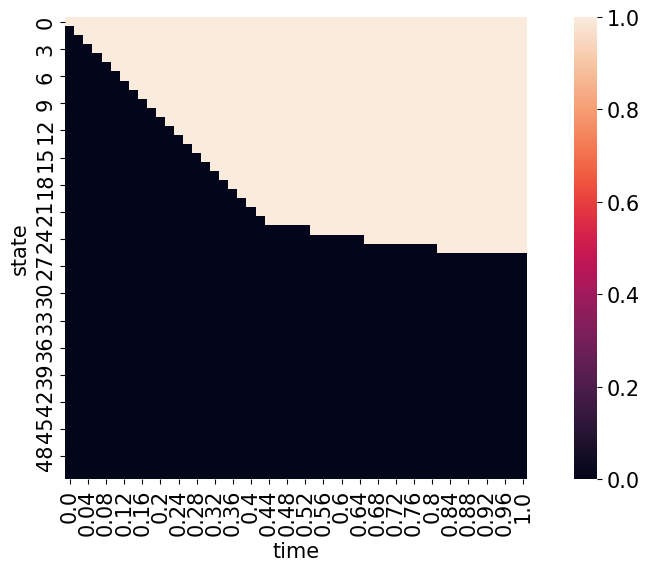

In [32]:
sns.heatmap(exercise_decisions(payoff, undertree=bondtreeT, derivtree=derivtree),square=True)